# Dimension reduction on raster data

Unsupervised data analytics are powerful tools for data exploration. A common method is the principal component analysis (PCA), which enables to analyze high-dimensional data. PCA is a dimension reduction method that derives common features across multiple dimensions (e.g. different environmental variables) into Principal components (vectors of join variation). This enables to reduce multiple, redundat variables into common latent variables but also enables to analyze common variation.

## Assignments
* load the MODIS data, calculate the montly NDVI and derive the maximum across months. Merge the data with the WorldClim data. Is the NDVI more related to precipiation or temperature? Try to interpret the results
    * Tip: You may load the MODIS data and then resample the WORDLCLIM and MODIS data using:
    
        ``` resampled_raster = raster_to_resample.rio.reproject_match(target_raster) ```

## Load packages, etc.

In [1]:
import rioxarray
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load and preprocess data

In [3]:
import glob

files = glob.glob('data/earth_obseration_products/worldclim_res/**/*.tif', recursive=True)
files

['data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_1.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_12.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_13-14.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_15.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_4.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_7.tif']

In [7]:
# open all files 
#rasters = [rioxarray.open_rasterio(rf) for rf in files]
rasters = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf, masked=True) for rf in files}
# coarsen the rasters to ease computional load
#rasters = [raster.coarsen(x=40, y=40).mean() for raster in rasters]

In [8]:
rasters['bio_12']

<xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
[1620000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  11256
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0

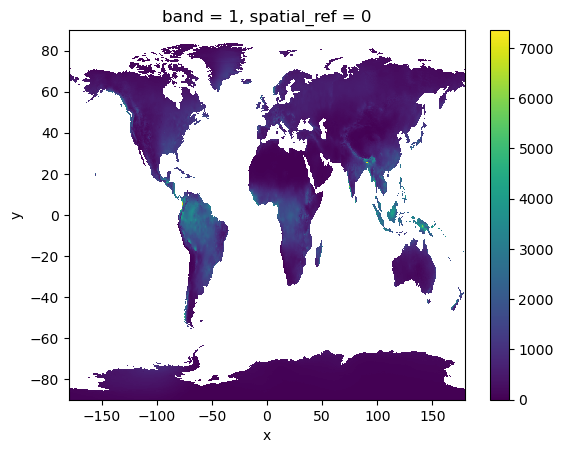

In [9]:
rasters['bio_12'].plot()

In [12]:

# Get the first raster
first_raster = rasters[next(iter(rasters))].values.flatten()

# Create an array of indices of non-NA values
#non_na_indices = np.arange(len(first_raster))[(first_raster > -3.400000e+37) & (first_raster < 3.400000e+37)]
non_na_indices = np.isnan(first_raster)
non_na_indices

array([ True,  True,  True, ..., False, False, False])

In [15]:
np.random.seed(0)

# Get the first raster
first_raster = rasters[next(iter(rasters))].values.flatten()

# Create an array of indices of non-NA values
non_na_indices = np.arange(len(first_raster))[np.isfinite(first_raster)]

# Draw random indices from the non-NA indices
index = np.random.choice(non_na_indices, 1000)

# Draw samples using the random indices
samples = pd.DataFrame({name: raster.values.flatten()[index] for name, raster in rasters.items()})

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,24.005407,3175.360107,203.271118,26.787094,29.250107,9.346668
1,-24.455482,525.546692,71.146667,46.494061,656.555908,24.900002
2,-3.585037,702.422241,75.040001,46.836536,1326.684326,45.204445
3,0.287704,482.168884,154.364441,123.969688,1398.889160,48.783112
4,20.987055,431.982208,51.200001,46.795547,613.437561,30.193777


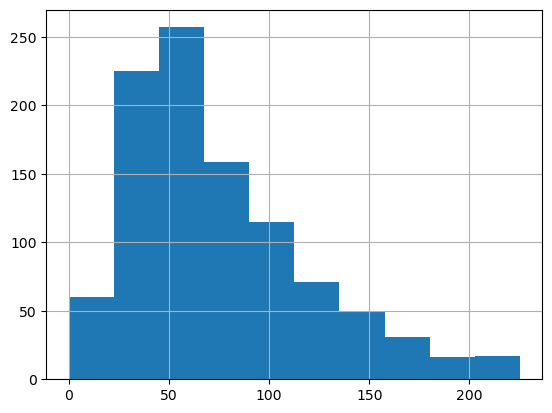

In [17]:
samples['bio_15'].hist()
samples.head()

In [18]:
# scale each column of samples to have mean 0 and variance 1
samples_scaled = samples.copy()
for col in samples_scaled.columns:
    samples_scaled[col] = (samples_scaled[col] - samples_scaled[col].mean()) / samples_scaled[col].std()

In [19]:
samples.head()

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,24.005407,3175.360107,203.271118,26.787094,29.250107,9.346668
1,-24.455482,525.546692,71.146667,46.494061,656.555908,24.900002
2,-3.585037,702.422241,75.040001,46.836536,1326.684326,45.204445
3,0.287704,482.168884,154.364441,123.969688,1398.889160,48.783112
4,20.987055,431.982208,51.200001,46.795547,613.437561,30.193777


In [20]:
samples_scaled.head()

,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,1.161899,3.805779,1.501827,-1.070658,-1.788219,-2.007175
1,-0.775699,-0.047380,-0.056591,-0.631699,-0.478224,-0.734767
2,0.058758,0.209819,-0.010669,-0.624070,0.921197,0.926327
3,0.213601,-0.110457,0.924969,1.094017,1.071982,1.219095
4,1.041217,-0.183434,-0.291864,-0.624983,-0.568267,-0.301687


In [21]:
# calculate a PCA based on the sampled values
from sklearn.decomposition import PCA

pca = PCA(n_components=6)  # lets test with 10 components (max components is the number of columns of the input dataset, but the last components are primarily noise anyway)
pca_result = pca.fit_transform(samples_scaled)

In [22]:
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance)

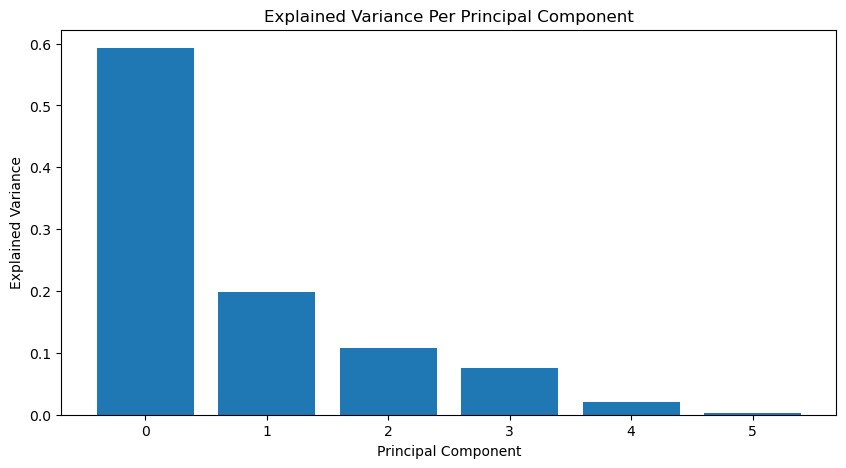

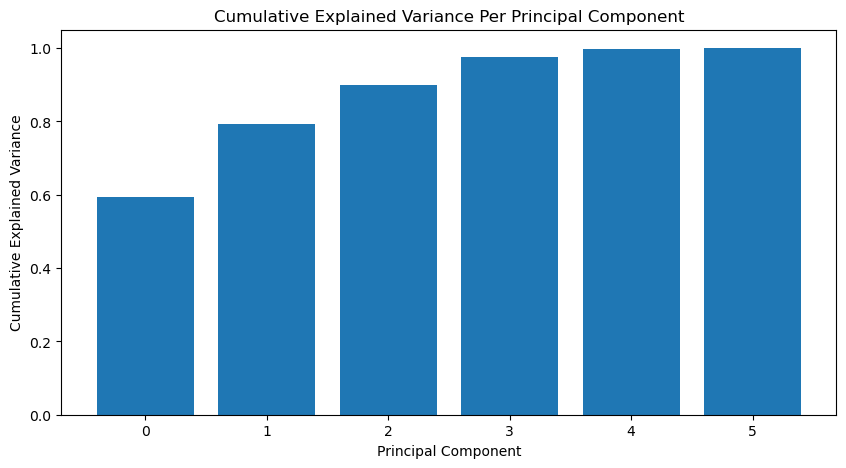

In [23]:
# Create a bar plot for the explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance)), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Per Principal Component')
plt.show()

# Create a bar plot for the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance_cumulative)), explained_variance_cumulative)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Per Principal Component')
plt.show()

In [24]:
print("Explained Variance: ", explained_variance)
print("Cumulative Explained Variance: ", explained_variance_cumulative)

Explained Variance:  [0.59272164 0.19892238 0.10829899 0.07628637 0.0211474  0.00262327]
Cumulative Explained Variance:  [0.59272164 0.79164404 0.89994305 0.9762294  0.9973768  1.0000001 ]


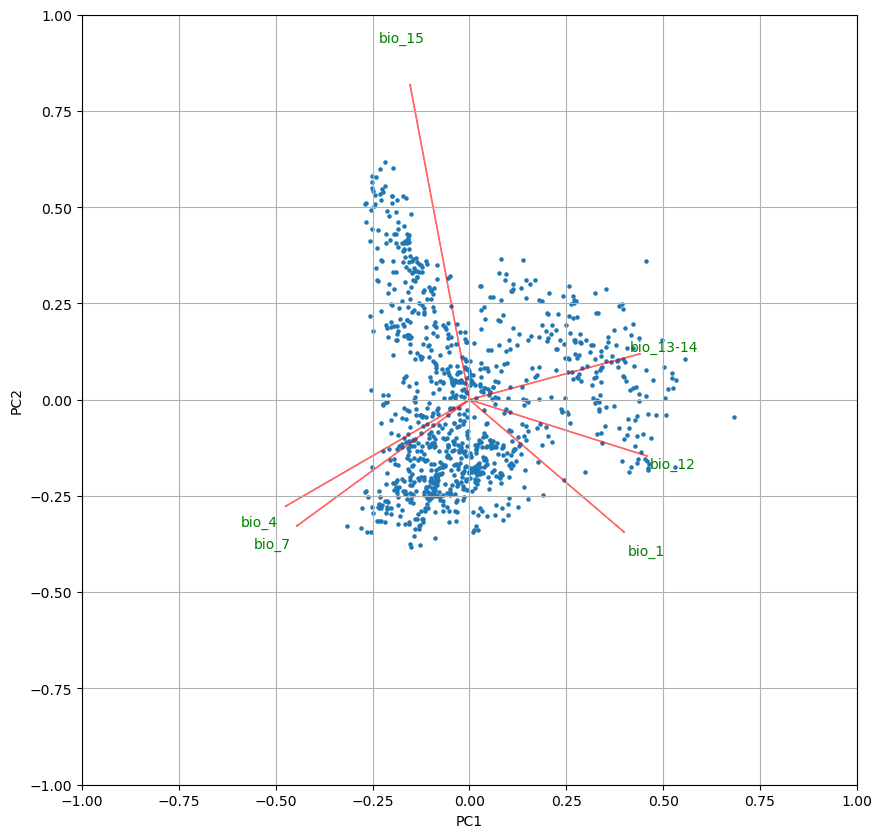

In [25]:
# create an ordination plot of the PCA with arrows indicating the direction of the original variables
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(10, 10))
    plt.scatter(xs * scalex,ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

# apply the biplot function
biplot(pca_result[:,0:2], np.transpose(pca.components_[0:2, :]), labels=samples.columns)

| Variable | Description                                       |
|----------|---------------------------------------------------|
| BIO1     | Annual Mean Temperature                           |
| BIO4     | Temperature Seasonality (standard deviation ×100) |
| BIO7     | Temperature Annual Range (BIO5-BIO6)             |
| BIO11    | Mean Temperature of Coldest Quarter              |
| BIO12    | Annual Precipitation                              |
| BIO13    | Precipitation of Wettest Month                   |
| BIO14    | Precipitation of Driest Month                    |
| BIO15    | Precipitation Seasonality (Coefficient of Variation) |

In [26]:

files = glob.glob('data/earth_obseration_products/modis/**/*.tif', recursive=True)
files

[]

In [27]:
# from a file list (raster_files) select the "band01" and "band04" of each month (m1, m2, etc.) to calculate the NDVI and append it to a list.

# Define the months
months = [f'm{i}' for i in range(1, 13)]

# Calculate NDVI for each month
ndvi_list = []
for month in months:
    # Find the files for the current month and band
    band01_file = next((file for file in files if f'_{month}_' in file and '_band01.' in file), None)
    band02_file = next((file for file in files if f'_{month}_' in file and '_band02.' in file), None)

    if band01_file and band02_file:
        # Load the red and NIR bands and (optionally) coarsen the data
        red = rioxarray.open_rasterio(band01_file).squeeze().coarsen(x=40, y=40).mean()
        nir = rioxarray.open_rasterio(band02_file).squeeze().coarsen(x=40, y=40).mean()

        # Calculate the NDVI
        ndvi = (nir - red) / (nir + red)

        # Append the NDVI raster to the list
        ndvi_list.append(ndvi)